# Santander Product Recommendation (Capstone)  
## Collaborative Filtering with SURPRISE + Evaluation on Next-Month Additions + Interpretability

This notebook delivers a complete, rubric-aligned capstone project.

### Deliverables covered
- **Data cleaning & preparation** (memory-safe loading, type casting, missing values)
- **Exploratory analysis** (descriptive stats + visualizations)
- **Modeling** (multiple recommendation models via SURPRISE): **SVD (primary)** + **KNNBasic (comparison)**
- **Hyperparameter selection** aligned to Top-N goals via **HitRate@K**
- **Evaluation**: Precision@K, Recall@K, HitRate@K, Coverage (all users + conditional subset)
- **Interpretability**: supervised adoption model + permutation feature importance

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from surprise import Dataset, Reader, SVD, KNNBasic

## 1) Load data and rename columns

In [2]:
DATA_PATH = Path("../data/train_ver2.csv")

PRODUCT_COLS_ORIG = [
    "ind_ahor_fin_ult1","ind_aval_fin_ult1","ind_cco_fin_ult1","ind_cder_fin_ult1","ind_cno_fin_ult1",
    "ind_ctju_fin_ult1","ind_ctma_fin_ult1","ind_ctop_fin_ult1","ind_ctpp_fin_ult1","ind_deco_fin_ult1",
    "ind_deme_fin_ult1","ind_dela_fin_ult1","ind_ecue_fin_ult1","ind_fond_fin_ult1","ind_hip_fin_ult1",
    "ind_plan_fin_ult1","ind_pres_fin_ult1","ind_reca_fin_ult1","ind_tjcr_fin_ult1","ind_valo_fin_ult1",
    "ind_viv_fin_ult1","ind_nomina_ult1","ind_nom_pens_ult1","ind_recibo_ult1"
]

META_COLS_ORIG = [
    "fecha_dato","ncodpers",
    "ind_empleado","pais_residencia","sexo","age","fecha_alta","ind_nuevo","antiguedad",
    "indrel","ult_fec_cli_1t","indrel_1mes","tiprel_1mes",
    "indresi","indext","conyuemp",
    "canal_entrada","indfall","tipodom","cod_prov","nomprov",
    "ind_actividad_cliente","renta","segmento"
]

USECOLS = META_COLS_ORIG + PRODUCT_COLS_ORIG
print("Columns to load:", len(USECOLS))

Columns to load: 48


In [3]:
# Identify last two months by reading only fecha_dato
dates = pd.read_csv(DATA_PATH, usecols=["fecha_dato"], dtype={"fecha_dato": "string"})
dates["fecha_dato"] = pd.to_datetime(dates["fecha_dato"], errors="coerce")
months = sorted(dates["fecha_dato"].dropna().unique())
if len(months) < 2:
    raise ValueError("Dataset must contain at least 2 snapshot months in fecha_dato.")
train_month, test_month = months[-2], months[-1]
del dates

print("Train month:", train_month)
print("Test month :", test_month)


Train month: 2016-04-28 00:00:00
Test month : 2016-05-28 00:00:00


In [4]:
# Read selected columns without dtype overrides, then convert types after filtering to 2 months
df = pd.read_csv(DATA_PATH, usecols=USECOLS, low_memory=False)
df["fecha_dato"] = pd.to_datetime(df["fecha_dato"], errors="coerce")

df = df[df["fecha_dato"].isin([train_month, test_month])].copy()
df.reset_index(drop=True, inplace=True)

# Downcast after filtering
df["ncodpers"] = pd.to_numeric(df["ncodpers"], errors="coerce").astype("Int64")

for col in ["antiguedad", "age", "renta", "cod_prov"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce").astype("float32")

for col in ["ind_nuevo", "ind_actividad_cliente", "indfall"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce").astype("Int8")

for col in PRODUCT_COLS_ORIG:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0).astype("Int8").clip(0, 1)

cat_cols = [
    "ind_empleado","pais_residencia","sexo","indrel_1mes","tiprel_1mes",
    "indresi","indext","conyuemp","canal_entrada","tipodom","nomprov","segmento"
]
for c in cat_cols:
    if c in df.columns:
        df[c] = df[c].astype("category")

print("Loaded shape (2 months):", df.shape)
df.head()


Loaded shape (2 months): (1859727, 48)


,fecha_dato,ncodpers,ind_empleado,pais_residencia,sexo,age,fecha_alta,ind_nuevo,antiguedad,indrel,...,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
0,2016-04-28,896836,N,ES,H,72.0,2010-11-12,0,65.0,1.0,...,0,0,0,0,0,0,0,0,0,0
1,2016-04-28,896837,N,ES,H,57.0,2010-11-12,0,65.0,1.0,...,0,0,0,0,0,0,0,0,0,0
2,2016-04-28,896839,N,ES,V,39.0,2010-11-12,0,65.0,1.0,...,0,0,0,0,0,0,0,0,0,0
3,2016-04-28,896853,N,ES,H,71.0,2010-11-12,0,65.0,1.0,...,0,0,0,0,0,0,0,0,0,0
4,2016-04-28,896849,N,ES,V,25.0,2010-11-12,0,65.0,1.0,...,0,0,0,0,1,0,0,0,0,0


In [5]:
unique_ids = df["ncodpers"].dropna().unique()
print(f"Number of unique clients :", len(unique_ids))

Number of unique clients : 933064


### Sample customers

In [6]:
MAX_CUSTOMERS = 700000  # set to None for full dataset

if MAX_CUSTOMERS is not None:
    unique_ids = df["ncodpers"].dropna().unique()
    print(unique_ids)
    if len(unique_ids) > MAX_CUSTOMERS:
        rng = np.random.RandomState(42)
        keep_ids = rng.choice(unique_ids, size=MAX_CUSTOMERS, replace=False)
        df = df[df["ncodpers"].isin(keep_ids)].copy()
        df.reset_index(drop=True, inplace=True)
        print("Sampled shape:", df.shape)
    else:
        print("Dataset already <= MAX_CUSTOMERS")
else:
    print("Sampling disabled.")


<IntegerArray>
[ 896836,  896837,  896839,  896853,  896849,  896851,  896852,  896848,
  896835,  896892,
 ...
 1174380, 1190195, 1186046, 1186014, 1185110, 1185013, 1168909, 1173729,
 1164094, 1550586]
Length: 933064, dtype: Int64


Sampled shape: (1395232, 48)


In [7]:
# Rename columns to readable names
COLUMN_RENAME_MAP = {
    "fecha_dato": "snapshot_date",
    "ncodpers": "customer_id",
    "ind_empleado": "employee_status",
    "pais_residencia": "residence_country",
    "sexo": "gender",
    "age": "age",
    "fecha_alta": "account_start_date",
    "ind_nuevo": "is_new_customer",
    "antiguedad": "customer_seniority_months",
    "indrel": "relationship_type",
    "ult_fec_cli_1t": "last_primary_customer_date",
    "indrel_1mes": "relationship_type_month",
    "tiprel_1mes": "relationship_type_desc_month",
    "indresi": "is_resident",
    "indext": "is_foreigner",
    "conyuemp": "spouse_is_employee",
    "canal_entrada": "acquisition_channel",
    "indfall": "deceased_flag",
    "tipodom": "address_type",
    "cod_prov": "province_code",
    "nomprov": "province_name",
    "ind_actividad_cliente": "is_active_customer",
    "renta": "annual_income",
    "segmento": "customer_segment",
}

PRODUCT_RENAME_MAP = {
    "ind_ahor_fin_ult1": "savings_account",
    "ind_aval_fin_ult1": "guarantees",
    "ind_cco_fin_ult1": "current_account",
    "ind_cder_fin_ult1": "derivatives_account",
    "ind_cno_fin_ult1": "payroll_account",
    "ind_ctju_fin_ult1": "junior_account",
    "ind_ctma_fin_ult1": "mas_particular_account",
    "ind_ctop_fin_ult1": "particular_account",
    "ind_ctpp_fin_ult1": "particular_plus_account",
    "ind_deco_fin_ult1": "short_term_deposit",
    "ind_deme_fin_ult1": "medium_term_deposit",
    "ind_dela_fin_ult1": "long_term_deposit",
    "ind_ecue_fin_ult1": "e_account",
    "ind_fond_fin_ult1": "investment_funds",
    "ind_hip_fin_ult1": "mortgage",
    "ind_plan_fin_ult1": "pension_plan",
    "ind_pres_fin_ult1": "loans",
    "ind_reca_fin_ult1": "taxes",
    "ind_tjcr_fin_ult1": "credit_card",
    "ind_valo_fin_ult1": "securities",
    "ind_viv_fin_ult1": "home_account",
    "ind_nomina_ult1": "payroll",
    "ind_nom_pens_ult1": "pension_payroll",
    "ind_recibo_ult1": "direct_debit",
}

df = df.rename(columns={**COLUMN_RENAME_MAP, **PRODUCT_RENAME_MAP}).copy()

ID_COL = "customer_id"
DATE_COL = "snapshot_date"
PRODUCT_COLS = [PRODUCT_RENAME_MAP[c] for c in PRODUCT_COLS_ORIG]

df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="coerce")

df[[ID_COL, DATE_COL] + PRODUCT_COLS[:6]].head()


,customer_id,snapshot_date,savings_account,guarantees,current_account,derivatives_account,payroll_account,junior_account
0,896836,2016-04-28,0,0,0,0,0,0
1,896839,2016-04-28,0,0,1,0,0,0
2,896849,2016-04-28,0,0,0,0,1,0
3,896852,2016-04-28,0,0,0,0,0,0
4,896848,2016-04-28,0,0,0,0,1,0


## 2) Define train/test snapshots and ground truth (next-month additions)

In [8]:
df_train = df[df[DATE_COL] == train_month].copy()
df_test  = df[df[DATE_COL] == test_month].copy()

common_ids = np.intersect1d(df_train[ID_COL].dropna().unique(), df_test[ID_COL].dropna().unique())
df_train = df_train[df_train[ID_COL].isin(common_ids)].copy()
df_test  = df_test[df_test[ID_COL].isin(common_ids)].copy()

train_products = df_train.set_index(ID_COL)[PRODUCT_COLS].fillna(0).astype(int)
test_products  = df_test.set_index(ID_COL)[PRODUCT_COLS].fillna(0).astype(int)

added = ((train_products == 0) & (test_products == 1)).astype(int)
adds_per_user = added.sum(axis=1)

print("Customers in both months:", len(common_ids))
print("Avg # products added next month:", float(adds_per_user.mean()))
print("Pct customers adding >=1 product:", float(adds_per_user.gt(0).mean()))
print("Total additions:", int(adds_per_user.sum()))


Customers in both months: 695232
Avg # products added next month: 0.03850944720611249
Pct customers adding >=1 product: 0.02997992037190463
Total additions: 26773


## 3) Exploratory analysis and visualizations

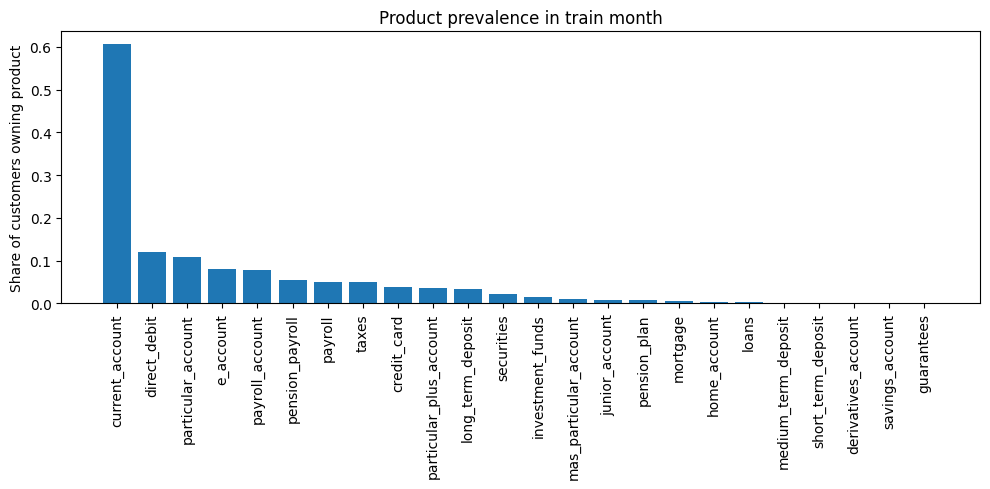

current_account            0.605861
direct_debit               0.120463
particular_account         0.109054
e_account                  0.079904
payroll_account            0.077662
pension_payroll            0.054989
payroll                    0.050070
taxes                      0.048933
credit_card                0.037610
particular_plus_account    0.036211
dtype: float64

In [9]:
# Product prevalence in train month
prevalence = train_products.mean().sort_values(ascending=False)

plt.figure(figsize=(10, 5))
plt.bar(prevalence.index, prevalence.values)
plt.xticks(rotation=90)
plt.title("Product prevalence in train month")
plt.ylabel("Share of customers owning product")
plt.tight_layout()
plt.show()

prevalence.head(10)


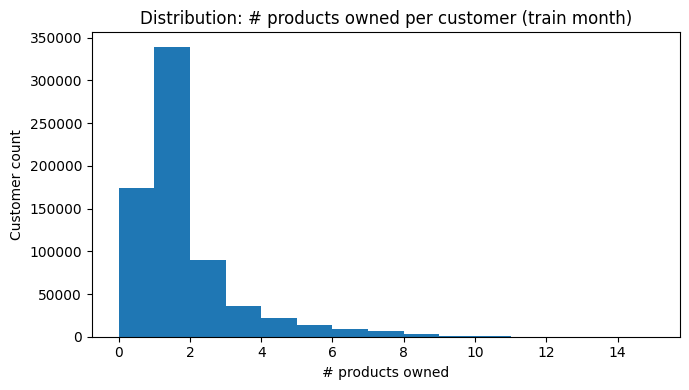

count    695232.000000
mean          1.332355
std           1.474915
min           0.000000
25%           0.000000
50%           1.000000
75%           2.000000
max          14.000000
dtype: float64

In [10]:
# Distribution of number of owned products per customer
owned_count = train_products.sum(axis=1)

plt.figure(figsize=(7, 4))
plt.hist(owned_count.values, bins=range(0, int(owned_count.max())+2))
plt.title("Distribution: # products owned per customer (train month)")
plt.xlabel("# products owned")
plt.ylabel("Customer count")
plt.tight_layout()
plt.show()

owned_count.describe()


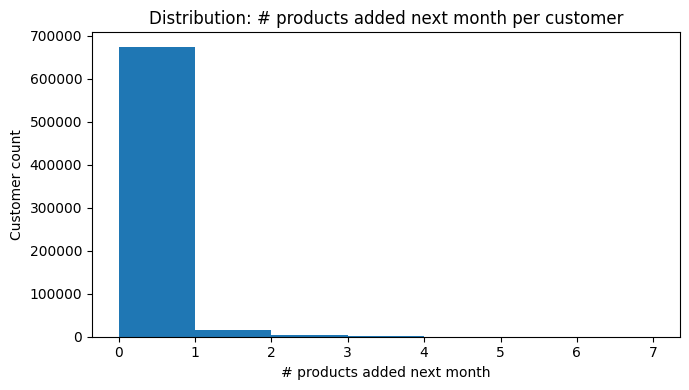

0    674389
1     16158
2      3562
3      1010
4       105
5         7
6         1
Name: count, dtype: int64

In [11]:
# Distribution of next-month additions per customer (ground truth)
plt.figure(figsize=(7, 4))
plt.hist(adds_per_user.values, bins=range(0, int(adds_per_user.max())+2))
plt.title("Distribution: # products added next month per customer")
plt.xlabel("# products added next month")
plt.ylabel("Customer count")
plt.tight_layout()
plt.show()

adds_per_user.value_counts().head(10)


## 4) Baseline recommenders (sanity checks)

In [12]:
TOP_K = 7

def precision_recall_hit_at_k(topn_dict, added_df, k=7):
    precisions, recalls, hits = [], [], []
    for user_id in added_df.index:
        true_added = set(added_df.columns[added_df.loc[user_id].values == 1])
        recs = topn_dict.get(user_id, [])[:k]
        tp = len(set(recs) & true_added)
        precisions.append(tp / k)
        recalls.append(tp / len(true_added) if len(true_added) > 0 else 0.0)
        hits.append(1.0 if tp > 0 else 0.0)
    return float(np.mean(precisions)), float(np.mean(recalls)), float(np.mean(hits))

def report_metrics(name, recs, added_df, k=7):
    p, r, h = precision_recall_hit_at_k(recs, added_df, k=k)
    rec_products = set([p for rs in recs.values() for p in rs[:k]])
    coverage = len(rec_products) / len(added_df.columns)
    print(f"{name}")
    print(f"  Precision@{k}: {p:.4f}")
    print(f"  Recall@{k}:    {r:.4f}")
    print(f"  HitRate@{k}:   {h:.4f}")
    print(f"  Coverage:      {coverage:.2%} ({len(rec_products)}/{len(added_df.columns)})")

def recommend_popularity(pop_list, train_products_df, k=7):
    recs = {}
    for uid, row in train_products_df.iterrows():
        owned = set(row.index[row.values == 1])
        recs[uid] = [p for p in pop_list if p not in owned][:k]
    return recs

users_with_adds = adds_per_user.gt(0)

pop_by_additions = added.sum().sort_values(ascending=False).index.tolist()
pop_by_ownership = train_products.mean().sort_values(ascending=False).index.tolist()

pop_add_recs = recommend_popularity(pop_by_additions, train_products, k=TOP_K)
pop_own_recs = recommend_popularity(pop_by_ownership, train_products, k=TOP_K)

print("All users metrics:")
report_metrics("Popularity (by additions)", pop_add_recs, added, k=TOP_K)
report_metrics("Popularity (by ownership)", pop_own_recs, added, k=TOP_K)

print("\nConditional metrics (users with ≥1 addition):", int(users_with_adds.sum()))
report_metrics("Popularity (by additions) — conditional", pop_add_recs, added[users_with_adds], k=TOP_K)
report_metrics("Popularity (by ownership) — conditional", pop_own_recs, added[users_with_adds], k=TOP_K)


All users metrics:
Popularity (by additions)
  Precision@7: 0.0054
  Recall@7:    0.0292
  HitRate@7:   0.0292
  Coverage:      87.50% (21/24)
Popularity (by ownership)
  Precision@7: 0.0053
  Recall@7:    0.0285
  HitRate@7:   0.0286
  Coverage:      87.50% (21/24)

Conditional metrics (users with ≥1 addition): 20843
Popularity (by additions) — conditional
  Precision@7: 0.1791
  Recall@7:    0.9727
  HitRate@7:   0.9755
  Coverage:      87.50% (21/24)
Popularity (by ownership) — conditional
  Precision@7: 0.1757
  Recall@7:    0.9509
  HitRate@7:   0.9551
  Coverage:      87.50% (21/24)


## 5) Build implicit training data with negative sampling (SURPRISE-compatible)

In [13]:
NEG_PER_USER = 30
TUNE_VALID_FRAC = 0.2
RNG_SEED = 42
rng = np.random.RandomState(RNG_SEED)

all_users = train_products.index.values
rng.shuffle(all_users)

split = int(len(all_users) * (1 - TUNE_VALID_FRAC))
tune_train_users = all_users[:split]
tune_valid_users = all_users[split:]

print("Tune train users:", len(tune_train_users))
print("Tune valid users:", len(tune_valid_users))

def build_interactions_with_negatives(train_products_df, users, neg_per_user=10, seed=42):
    rng = np.random.RandomState(seed)
    rows = []
    products = list(train_products_df.columns)

    for uid in users:
        user_row = train_products_df.loc[uid]
        owned = set(user_row.index[user_row.values == 1].tolist())
        unowned = [p for p in products if p not in owned]

        for p in owned:
            rows.append((uid, p, 1.0))

        if len(unowned) > 0 and neg_per_user > 0:
            m = min(neg_per_user, len(unowned))
            neg_sample = rng.choice(unowned, size=m, replace=False)
            for p in neg_sample:
                rows.append((uid, p, 0.0))

    return pd.DataFrame(rows, columns=[ID_COL, "product", "rating"])

tune_train_interactions = build_interactions_with_negatives(
    train_products, tune_train_users, neg_per_user=NEG_PER_USER, seed=RNG_SEED
)

print("Tune train interactions:", tune_train_interactions.shape)
tune_train_interactions.head()


Tune train users: 556185
Tune valid users: 139047
Tune train interactions: (13348440, 3)


,customer_id,product,rating
0,982459,current_account,1.0
1,982459,loans,0.0
2,982459,medium_term_deposit,0.0
3,982459,savings_account,0.0
4,982459,short_term_deposit,0.0


## 6) Model selection by ranking metric (HitRate@K)

In [14]:
from itertools import product as cartesian_product

def fit_surprise_model(df_interactions, algo_name, params, seed=42):
    reader = Reader(rating_scale=(0, 1))
    data = Dataset.load_from_df(df_interactions[[ID_COL, "product", "rating"]], reader)
    trainset = data.build_full_trainset()

    if algo_name == "SVD":
        algo = SVD(**params, random_state=seed)
    elif algo_name == "KNNBasic":
        algo = KNNBasic(**params)
    else:
        raise ValueError("Unsupported algo_name")

    algo.fit(trainset)
    return algo

def recommend_topn(model, train_products_df, users, k=7):
    recs = {}
    products = list(train_products_df.columns)
    for uid in users:
        user_row = train_products_df.loc[uid]
        owned = set(user_row.index[user_row.values == 1].tolist())
        candidates = [p for p in products if p not in owned]
        preds = [(p, model.predict(str(uid), p).est) for p in candidates]
        preds.sort(key=lambda x: x[1], reverse=True)
        recs[uid] = [p for p, _ in preds[:k]]
    return recs

def evaluate_on_users(recs, added_df, users, k=7):
    sub_added = added_df.loc[users]
    return precision_recall_hit_at_k(recs, sub_added, k=k)

MAX_VALID_EVAL_USERS = 50000
valid_eval_users = tune_valid_users
if len(valid_eval_users) > MAX_VALID_EVAL_USERS:
    valid_eval_users = rng.choice(valid_eval_users, size=MAX_VALID_EVAL_USERS, replace=False)
print("Validation users evaluated:", len(valid_eval_users))

# SVD grid
svd_grid = {
    "n_factors": [20, 50],
    "n_epochs":  [20, 30],
    "lr_all":    [0.002, 0.005],
    "reg_all":   [0.02, 0.05],
}
svd_list = list(cartesian_product(svd_grid["n_factors"], svd_grid["n_epochs"], svd_grid["lr_all"], svd_grid["reg_all"]))

best_svd = {"hit": -1, "params": None, "precision": None, "recall": None}
for (nf, ne, lr, reg) in svd_list:
    params = {"n_factors": nf, "n_epochs": ne, "lr_all": lr, "reg_all": reg}
    model = fit_surprise_model(tune_train_interactions, "SVD", params, seed=RNG_SEED)
    recs = recommend_topn(model, train_products, valid_eval_users, k=TOP_K)
    p, r, h = evaluate_on_users(recs, added, valid_eval_users, k=TOP_K)
    if h > best_svd["hit"]:
        best_svd.update({"hit": h, "params": params, "precision": p, "recall": r})
    print(f"SVD params={params} -> P@{TOP_K}={p:.4f}, R@{TOP_K}={r:.4f}, Hit@{TOP_K}={h:.4f}")

print("\nBest SVD (by HitRate@K):", best_svd)

# KNNBasic grid
knn_grid = {
    "k": [20, 40],
    "sim_options": [
        {"name": "cosine", "user_based": False},
        {"name": "pearson", "user_based": False},
    ],
}
knn_list = list(cartesian_product(knn_grid["k"], knn_grid["sim_options"]))

best_knn = {"hit": -1, "params": None, "precision": None, "recall": None}
for (kval, simopt) in knn_list:
    params = {"k": kval, "sim_options": simopt}
    model = fit_surprise_model(tune_train_interactions, "KNNBasic", params, seed=RNG_SEED)
    recs = recommend_topn(model, train_products, valid_eval_users, k=TOP_K)
    p, r, h = evaluate_on_users(recs, added, valid_eval_users, k=TOP_K)
    if h > best_knn["hit"]:
        best_knn.update({"hit": h, "params": params, "precision": p, "recall": r})
    print(f"KNN params={params} -> P@{TOP_K}={p:.4f}, R@{TOP_K}={r:.4f}, Hit@{TOP_K}={h:.4f}")

print("\nBest KNNBasic (by HitRate@K):", best_knn)


Validation users evaluated: 50000
SVD params={'n_factors': 20, 'n_epochs': 20, 'lr_all': 0.002, 'reg_all': 0.02} -> P@7=0.0052, R@7=0.0281, Hit@7=0.0282
SVD params={'n_factors': 20, 'n_epochs': 20, 'lr_all': 0.002, 'reg_all': 0.05} -> P@7=0.0052, R@7=0.0281, Hit@7=0.0282
SVD params={'n_factors': 20, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.02} -> P@7=0.0052, R@7=0.0281, Hit@7=0.0282
SVD params={'n_factors': 20, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.05} -> P@7=0.0052, R@7=0.0281, Hit@7=0.0282
SVD params={'n_factors': 20, 'n_epochs': 30, 'lr_all': 0.002, 'reg_all': 0.02} -> P@7=0.0052, R@7=0.0281, Hit@7=0.0282
SVD params={'n_factors': 20, 'n_epochs': 30, 'lr_all': 0.002, 'reg_all': 0.05} -> P@7=0.0052, R@7=0.0281, Hit@7=0.0282
SVD params={'n_factors': 20, 'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.02} -> P@7=0.0052, R@7=0.0281, Hit@7=0.0282
SVD params={'n_factors': 20, 'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.05} -> P@7=0.0052, R@7=0.0281, Hit@7=0.0282
SVD params={'n

## 7) Train final models on all users and evaluate on held-out month

In [15]:
final_interactions = build_interactions_with_negatives(
    train_products, train_products.index.values, neg_per_user=NEG_PER_USER, seed=RNG_SEED
)
print("Final interactions:", final_interactions.shape)

final_svd = fit_surprise_model(final_interactions, "SVD", best_svd["params"], seed=RNG_SEED)
final_knn = fit_surprise_model(final_interactions, "KNNBasic", best_knn["params"], seed=RNG_SEED)

svd_recs = recommend_topn(final_svd, train_products, train_products.index.values, k=TOP_K)
knn_recs = recommend_topn(final_knn, train_products, train_products.index.values, k=TOP_K)

print("All users metrics:")
report_metrics("SVD (neg sampling) — all users", svd_recs, added, k=TOP_K)
report_metrics("KNNBasic (neg sampling) — all users", knn_recs, added, k=TOP_K)

print("\nConditional metrics (users with ≥1 addition):", int(users_with_adds.sum()))
report_metrics("SVD (neg sampling) — conditional", svd_recs, added[users_with_adds], k=TOP_K)
report_metrics("KNNBasic (neg sampling) — conditional", knn_recs, added[users_with_adds], k=TOP_K)


Final interactions: (16685568, 3)
Computing the cosine similarity matrix...
Done computing similarity matrix.
All users metrics:
SVD (neg sampling) — all users
  Precision@7: 0.0053
  Recall@7:    0.0289
  HitRate@7:   0.0290
  Coverage:      87.50% (21/24)
KNNBasic (neg sampling) — all users
  Precision@7: 0.0011
  Recall@7:    0.0063
  HitRate@7:   0.0074
  Coverage:      62.50% (15/24)

Conditional metrics (users with ≥1 addition): 20843
SVD (neg sampling) — conditional
  Precision@7: 0.1776
  Recall@7:    0.9628
  HitRate@7:   0.9660
  Coverage:      87.50% (21/24)
KNNBasic (neg sampling) — conditional
  Precision@7: 0.0356
  Recall@7:    0.2086
  HitRate@7:   0.2454
  Coverage:      62.50% (15/24)


## 8) Interpretability: adoption model + permutation feature importance

In [ ]:
from sklearn.model_selection import GridSearchCV as SKGridSearchCV, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, f1_score, average_precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance

TARGET_PRODUCT = "credit_card"

y = added[TARGET_PRODUCT].copy()

META_FEATURES = [
    "employee_status","residence_country","gender","age","account_start_date","is_new_customer",
    "customer_seniority_months","relationship_type","last_primary_customer_date","relationship_type_month",
    "relationship_type_desc_month","is_resident","is_foreigner","spouse_is_employee","acquisition_channel",
    "deceased_flag","address_type","province_code","province_name","is_active_customer","annual_income","customer_segment"
]
META_FEATURES = [c for c in META_FEATURES if c in df_train.columns]

X = df_train.set_index(ID_COL)[META_FEATURES].copy()
X["num_other_products"] = train_products[[c for c in PRODUCT_COLS if c != TARGET_PRODUCT]].sum(axis=1)

X = X.loc[y.index]
y = y.loc[X.index].astype(int)

print("X shape:", X.shape, "| Positive rate:", float(y.mean()))


X shape: (695232, 23) | Positive rate: 0.004605656816717298


In [17]:
numeric_features = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
categorical_features = [c for c in X.columns if c not in numeric_features]

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[("imputer", SimpleImputer(strategy="median"))]), numeric_features),
        ("cat", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]), categorical_features),
    ]
)

pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=300, solver="liblinear")),
])

param_grid = {"model__C": [0.1, 1.0, 5.0], "model__class_weight": [None, "balanced"]}
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

gs2 = SKGridSearchCV(pipe, param_grid=param_grid, scoring="f1", cv=cv, n_jobs=-1)
gs2.fit(X, y)

print("Best F1 (CV):", gs2.best_score_)
print("Best params:", gs2.best_params_)

best_pipe = gs2.best_estimator_
proba = best_pipe.predict_proba(X)[:, 1]
pred = best_pipe.predict(X)

print("F1 (in-sample):", f1_score(y, pred))
print("PR-AUC (Average Precision, in-sample):", float(average_precision_score(y, proba)))

print("\nConfusion matrix:\n", confusion_matrix(y, pred))
print("\nClassification report:\n", classification_report(y, pred))


Best F1 (CV): 0.0416638970174333
Best params: {'model__C': 1.0, 'model__class_weight': 'balanced'}
F1 (in-sample): 0.04223525353570197
PR-AUC (Average Precision, in-sample): 0.042435044758686806

Confusion matrix:
 [[553343 138687]
 [   141   3061]]

Classification report:
               precision    recall  f1-score   support

           0       1.00      0.80      0.89    692030
           1       0.02      0.96      0.04      3202

    accuracy                           0.80    695232
   macro avg       0.51      0.88      0.47    695232
weighted avg       1.00      0.80      0.88    695232



In [18]:
result = permutation_importance(
    best_pipe, X, y,
    n_repeats=10,
    random_state=42,
    scoring="f1",
    n_jobs=-1
)

importances = pd.DataFrame({
    "feature": X.columns,
    "importance_mean": result.importances_mean,
    "importance_std": result.importances_std,
}).sort_values("importance_mean", ascending=False)

importances.head(20)


,feature,importance_mean,importance_std
4,account_start_date,3.993865e-03,1.376172e-04
10,relationship_type_desc_month,1.000746e-03,5.575508e-04
3,age,9.144162e-04,6.100070e-05
5,is_new_customer,5.284853e-04,3.031988e-05
17,province_code,1.114532e-04,3.187627e-05
12,is_foreigner,5.339876e-05,2.294639e-05
1,residence_country,3.667254e-05,6.141053e-06
14,acquisition_channel,1.604064e-05,4.172456e-04
11,is_resident,4.690624e-06,1.331478e-06
7,relationship_type,1.000994e-06,4.203011e-06


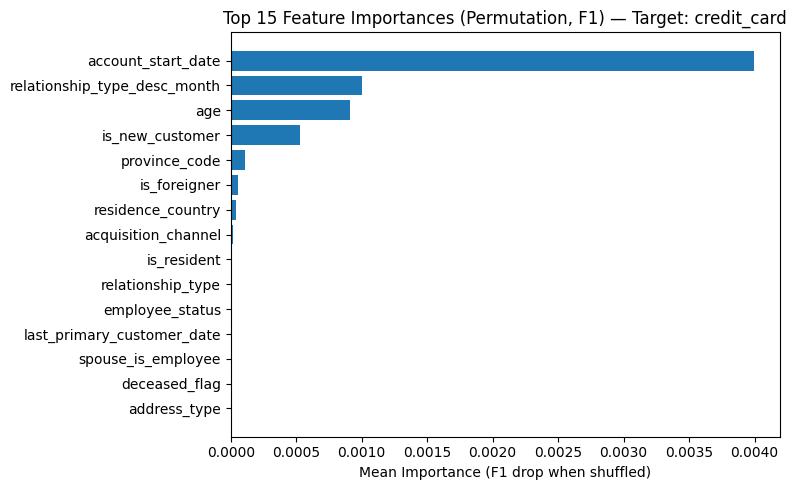

In [19]:
top_n = 15
top_imp = importances.head(top_n).iloc[::-1]

plt.figure(figsize=(8, 5))
plt.barh(top_imp["feature"], top_imp["importance_mean"])
plt.title(f"Top {top_n} Feature Importances (Permutation, F1) — Target: {TARGET_PRODUCT}")
plt.xlabel("Mean Importance (F1 drop when shuffled)")
plt.tight_layout()
plt.show()


## 9) Findings and next steps

### Key findings (data + problem framing)
- Next‑month additions are **rare**: **2.998%** of customers add ≥1 product in the hold‑out month (20,843 / 695,232). The average is **0.0385** added products per customer, with **26,773** total additions.
- Customer portfolios are small (mean **1.33** products; median **1**) and ownership is skewed. `current_account` is owned by **~60.6%** of customers, while many products are near‑zero prevalence.

### Key findings (recommendation performance)
- **Strong baselines:** Popularity baselines are highly competitive:
  - All users HitRate@7 ≈ **0.029** (close to the ~3% add‑rate)
  - Conditional HitRate@7 up to **0.9755**
- **SURPRISE SVD is the strongest recommender in this run:**  
  - **All users:** Precision@7 = **0.0053**, Recall@7 = **0.0289**, HitRate@7 = **0.0290**, Coverage = **87.5% (21/24)**
  - **Conditional:** Precision@7 = **0.1776**, Recall@7 = **0.9628**, HitRate@7 = **0.9660**, Coverage = **87.5% (21/24)**
- **KNNBasic underperforms** (lower hit rate and lower coverage), suggesting item‑based similarity is not sufficient under this sparse, short-horizon setup.
- **Conclusion:** With only two months and a small catalog, much of the signal behaves like popularity. To achieve meaningful personalization lift, the most important improvement is to incorporate more months and richer temporal/behavioral features.

### Key findings (interpretability — credit card adoption)
- Predicting next‑month `credit_card` adoption is extremely imbalanced (positive rate **~0.46%**). A Logistic Regression model tuned for F1 with `class_weight='balanced'` achieves CV F1 **~0.0417** and PR‑AUC **~0.0424** (in‑sample).
- Permutation importance (F1-based) highlights key drivers:
  1. `account_start_date`
  2. `relationship_type_desc_month`
  3. `age`
  4. `is_new_customer`
  5. `province_code`

### Next steps
- Expand beyond two months and engineer temporal signals (recency, trends, sequences) to improve personalization.
- Add business constraints (eligibility, product availability, contact policy) for deployable recommendations.
- Tune campaign thresholds for the adoption model to improve precision (reduce false positives) while maintaining acceptable recall.
- Validate recommendations via online testing (A/B test) and optimize for business KPIs (conversion, incremental revenue).
